## Projeto Lógico


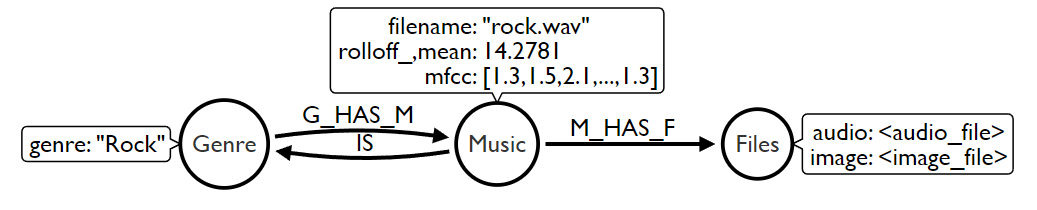

In [2]:
from IPython.display import Image
Image("Images/logico.png")


## Criando a classe para comunicação com o Banco de dados


In [1]:
from neo4j import GraphDatabase

class GTZAN:
    def __init__(self, uri, user, pwd):
        self._driver = GraphDatabase.driver(uri, auth=(user, pwd))

    def close(self):
        self._driver.close()

    def create_genre(self, genre):
        with self._driver.session() as session:
            session.run("CREATE (g:Genre {genre: $genre})", genre=genre)
            
    def create_music(self, genre, filename, rolloff_mean, mfcc):
        with self._driver.session() as session:
            session.run("MATCH (g:Genre) WHERE g.genre = $genre "
                        "CREATE (g)-[r:G_HAS_M]->(m:Music {filename: $filename, rolloff_mean: $rolloff_mean, mfcc: $mfcc})"
                        "CREATE (m)-[s:IS]->(g)", 
                        genre=genre, filename=filename, rolloff_mean=rolloff_mean, mfcc=mfcc)
    
    def create_files(self, filename, audio, image):
        with self._driver.session() as session:
            session.run("MATCH (m:Music) WHERE m.filename = $filename "
                        "CREATE (m)-[r:M_HAS_F]->(f:File {audio: $audio, image: $image})", 
                        filename=filename, audio=audio, image=image)
            
    def execute_query(self, query, param = {}):
        records, summary, keys = self._driver.execute_query(query, param)
        print(f"{len(records)} resultados encontrados em: {summary.result_available_after} ms")
        return records, summary


In [2]:
data = GTZAN("bolt://localhost:7687","neo4j","12345678")

## Inserindo as informações no Banco de Dados


In [2]:
import pandas as pd

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
data30s = pd.read_csv("Data/features_30_sec.csv")
data3s = pd.read_csv("Data/features_3_sec.csv")

### Criando os nós de gênero musical


In [4]:
for genre in genres:
    data.create_genre(genre)

Criando os nós de música e de arquivos


In [6]:
import os
from bson.binary import Binary

root_music_dir = 'Data\genres_original'
root_image_dir = 'Data\images_original'

def find_music(genre, filename):
        # Função para pegar o arquivo .wav com o filename e retornar ele escrito em binário 
	genre_dir = os.path.join(root_music_dir, genre)
	audio_path = os.path.join(genre_dir, filename)
	try:
		with open(audio_path, 'rb') as f:
			encoded_audio = f.read()
	except:
		encoded_audio = None
   
	return encoded_audio

def find_image(genre, filename):
        # Função para pegar o arquivo .png com o filename e retornar ele escrito em binário 
	genre_dir = os.path.join(root_image_dir, genre)
	audio_path = os.path.join(genre_dir, filename[:-10]+filename[-9:-4]+'.png')
  
	try:
		with open(audio_path, 'rb') as f:
			encoded_image = Binary(f.read())
	except:
		encoded_image = None
	return encoded_image

In [1]:
for genre in genres:
	print("Processando: " + genre)
	query = "label == '" + genre + "'"
	conj30s = data30s.query(query)
	conj3s = data3s.query(query)
	for index, row in conj30s.iterrows():
		# Pegando as informações de interesse
		filename = row["filename"]
		rolloff = row["rolloff_mean"]
		mfcc = []
  
		segments = conj3s[conj3s['filename'].str.contains(row["filename"][:-4])]
  
		for index_seg, row_seg in segments.iterrows():
			for i in range(1,21):
				mfcc_mean = "mfcc" + str(i) + "_mean"
				mfcc.append(row_seg[mfcc_mean])
		
		data.create_music(genre, filename, rolloff, mfcc)
		data.create_files(filename,find_music(genre, filename),find_image(genre, filename))

NameError: name 'genres' is not defined

## Consultas no banco de dados

As consultas são feitas a partir de uma query passada para a seguinte função da classe GTZAN:

```
def execute_query(self, query, param = {}):
        records, summary, keys = self._driver.execute_query(query, param)
        print(f"{len(records)} resultados encontrados em: {summary.result_available_after} ms")
        return records, summary
```


### Gênero musical


In [68]:
query = "MATCH (g:Genre)-[:G_HAS_M]->(m:Music) WHERE g.genre = $genre RETURN m"
param = {'genre': 'rock'}


results, summary = data.execute_query(query, param)

# Visualizando o resultado
for result in results:
        print(f"{result.data()['m']['filename']}")

100 resultados encontrados em: 1 ms
rock.00025.wav
rock.00099.wav
rock.00098.wav
rock.00097.wav
rock.00096.wav
rock.00095.wav
rock.00094.wav
rock.00093.wav
rock.00092.wav
rock.00091.wav
rock.00090.wav
rock.00089.wav
rock.00088.wav
rock.00087.wav
rock.00086.wav
rock.00085.wav
rock.00084.wav
rock.00083.wav
rock.00082.wav
rock.00081.wav
rock.00080.wav
rock.00079.wav
rock.00078.wav
rock.00077.wav
rock.00076.wav
rock.00075.wav
rock.00074.wav
rock.00073.wav
rock.00072.wav
rock.00071.wav
rock.00070.wav
rock.00069.wav
rock.00068.wav
rock.00067.wav
rock.00066.wav
rock.00065.wav
rock.00064.wav
rock.00063.wav
rock.00062.wav
rock.00061.wav
rock.00060.wav
rock.00059.wav
rock.00058.wav
rock.00057.wav
rock.00056.wav
rock.00055.wav
rock.00054.wav
rock.00053.wav
rock.00052.wav
rock.00051.wav
rock.00050.wav
rock.00049.wav
rock.00048.wav
rock.00047.wav
rock.00046.wav
rock.00045.wav
rock.00044.wav
rock.00043.wav
rock.00042.wav
rock.00041.wav
rock.00040.wav
rock.00039.wav
rock.00038.wav
rock.00037.wav
rock

Visualização do resultado da query em formato de nós obtida pelo software Neo4j Browser:


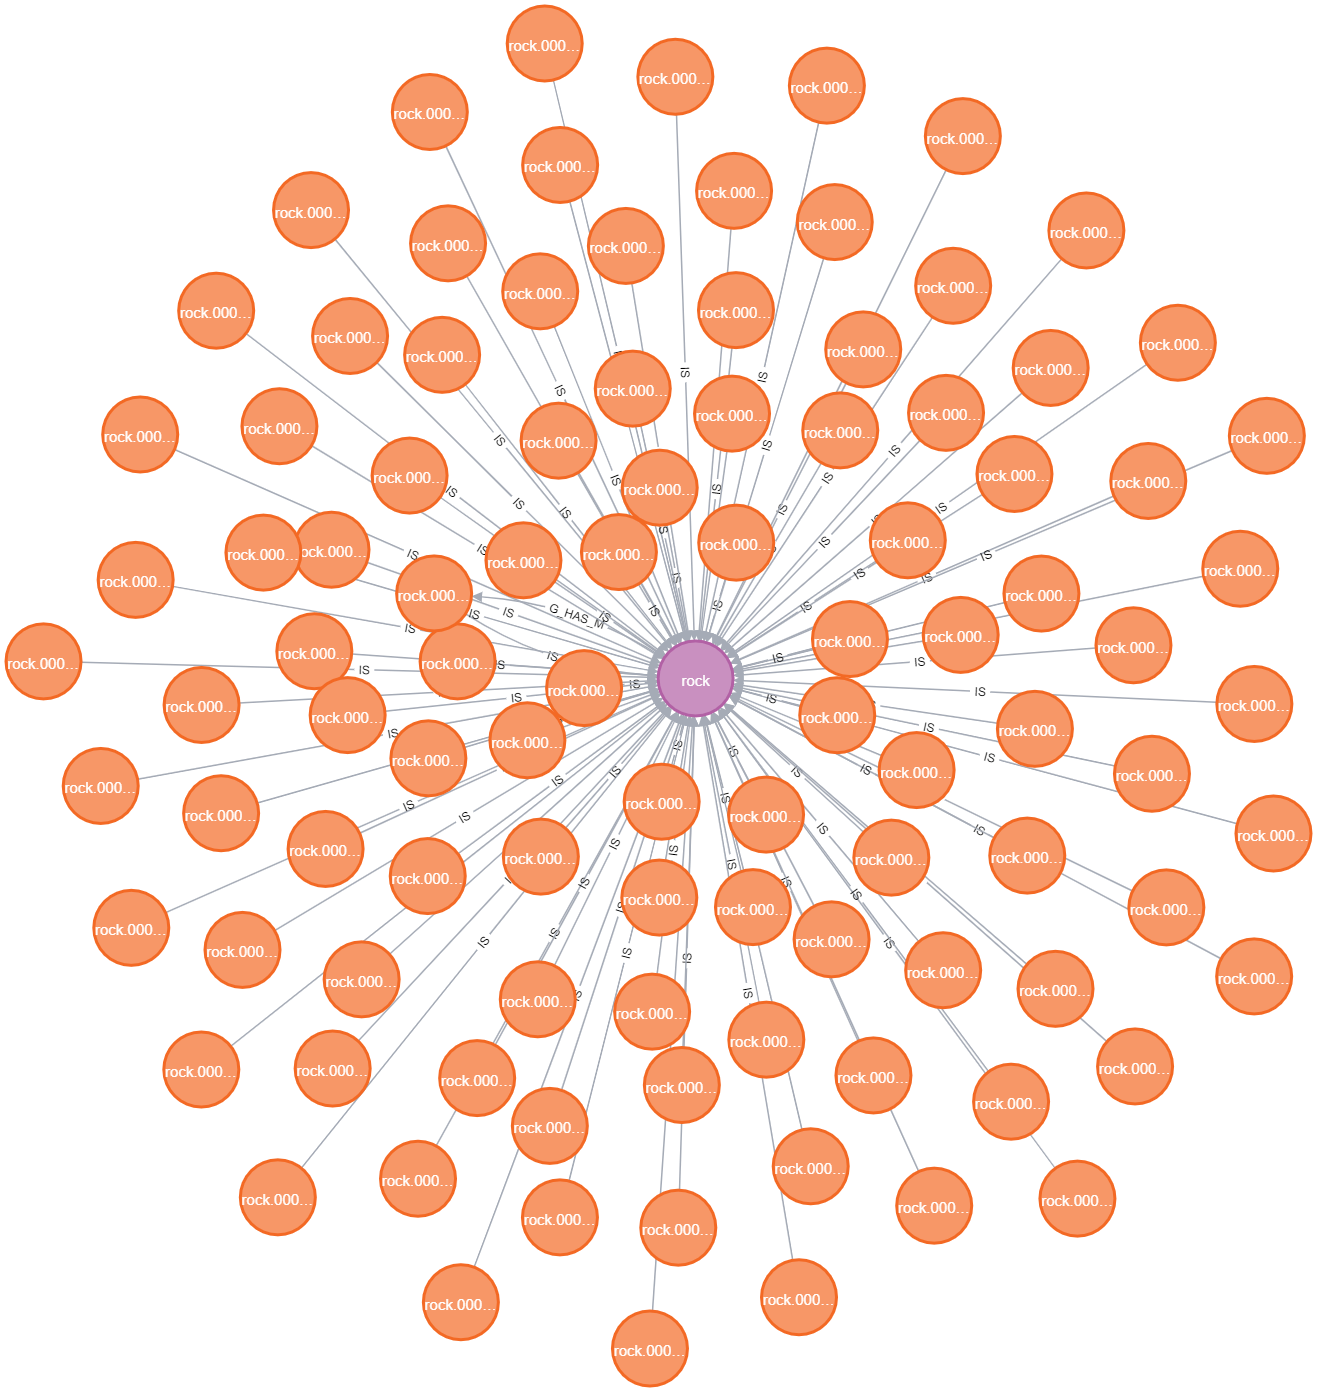

In [3]:
Image("Images/consulta_genero.png")

### Música com maior rolloff


In [69]:
query = "MATCH (m:Music) RETURN m ORDER BY m.rolloff_mean DESC LIMIT 1"

results, summary = data.execute_query(query)
for result in results:
        print(f"{result.data()['m']['filename']}")

1 resultados encontrados em: 93 ms
pop.00051.wav


Visualização do resultado da query em formato de nós obtida pelo software Neo4j Browser:


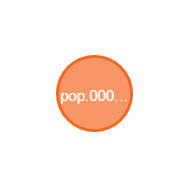

In [4]:
Image("Images/consulta_rolloff.png")

### Média de rolloff por gênero musical


In [74]:
query = """
	MATCH (m:Music)-[:IS]->(g:Genre)
	RETURN g.genre AS Genre, AVG(m.rolloff_mean) AS AverageRolloffMean
	"""

results, summary = data.execute_query(query)
for result in results:
    print(f"Genre: {result['Genre']}, Average Rolloff Mean: {result['AverageRolloffMean']}")

10 resultados encontrados em: 1 ms
Genre: blues, Average Rolloff Mean: 3640.190143462855
Genre: classical, Average Rolloff Mean: 2482.3259821322295
Genre: country, Average Rolloff Mean: 3949.5771658707927
Genre: disco, Average Rolloff Mean: 5519.791819519077
Genre: hiphop, Average Rolloff Mean: 5333.623850903359
Genre: jazz, Average Rolloff Mean: 3750.174279539513
Genre: metal, Average Rolloff Mean: 5125.230254631308
Genre: pop, Average Rolloff Mean: 6654.772975275523
Genre: reggae, Average Rolloff Mean: 4593.939352296625
Genre: rock, Average Rolloff Mean: 4669.18020766107


### Consulta por arquivos


Na consulta por arquivos, o resultado é escrito na pasta 'Data/retrieved_data/tipo_do_arquivo'


In [5]:
import os

# Para deletar os arquivos criados nas consultas
def deletar_arquivos(pasta):
    for nome_arquivo in os.listdir(pasta):
        caminho_arquivo = os.path.join(pasta, nome_arquivo)
        if os.path.isfile(caminho_arquivo):
            os.remove(caminho_arquivo)

#### Audio


In [18]:
query = """
	MATCH (g:Genre)-[:G_HAS_M]->(m:Music)-[:M_HAS_F]->(f:File)
	WHERE g.genre = 'rock'
	RETURN m.filename AS filename,f.audio AS audiofile 
	"""

results, summary = data.execute_query(query)

start = time.time()
for result in results:
        filename = result.data()['filename']
        if result.data()['audiofile']:
            with open("Data/retrieved_data/audio/"+filename,"wb") as f:
                f.write(result.data()['audiofile'])
end = time.time()

print(f"Para escrever todos os arquivos de áudio levou {end - start} segundos")

100 resultados encontrados em: 1 ms
Para escrever todos os arquivos de áudio levou 594.7093727588654 segundos


In [6]:
deletar_arquivos('Data/retrieved_data/audio/')

#### Imagens


In [19]:
query = """
MATCH (g:Genre)-[:G_HAS_M]->(m:Music)-[:M_HAS_F]->(f:File)
WHERE g.genre = 'rock'
RETURN m.filename AS filename, f.image AS imagefile
"""

results, summary = data.execute_query(query)

start = time.time()
for result in results:
        filename = result.data()['filename']
        if result.data()['imagefile']:
            with open("Data/retrieved_data/image/"+filename[:-3]+'png',"wb") as f:
                f.write(result.data()['imagefile'])
end = time.time()

print(f"Para escrever todos os arquivos de imagem levou {end - start} segundos")

100 resultados encontrados em: 0 ms
Para escrever todos os arquivos de imagem levou 38.919596672058105 segundos


In [21]:
deletar_arquivos('Data/retrieved_data/image/')

### Similaridade entre músicas


#### Similaridade por coeficiente de pearson


In [26]:
from scipy.stats import pearsonr
import pandas as pd

def achar_similaridade(genre, filename):
        genre = str(genre)
        filename = str(filename)
        
        filename_similar = []
        correlation = []
        
        query = "MATCH (m:Music)-[:IS]->(g:Genre) WHERE g.genre = '" + genre + "' AND m.filename = '" + filename + "'"
        query = query + " RETURN m.mfcc AS mfcc"
        print(query)
        music, summary = data.execute_query(query)
        
        if len(music) == 0:
                return None
        
        mfcc1 = music[0].data()['mfcc']

        query = ""
        query = "MATCH (m:Music)-[:IS]->(g:Genre) WHERE g.genre = '" + genre + "' AND m.filename <> '"+ filename + "' RETURN m.filename AS filename, m.mfcc AS mfcc"
        other_musics, summary = data.execute_query(query)
        
        if len(other_musics) == 0:
                return None
        
        for m in other_musics:
                fn = m.data()['filename']
                mfcc2 = m.data()['mfcc']
                
                if len(mfcc1) != len(mfcc2):
                        
                        if len(mfcc1) > len(mfcc2):
                                corr, _ = pearsonr(mfcc1[:len(mfcc2)], mfcc2)
                        else:
                                corr, _ = pearsonr(mfcc1, mfcc2[:len(mfcc1)])

                        if corr > 0.95:
                                        filename_similar.append(fn)
                                        correlation.append(corr)
                else:
                        corr, _ = pearsonr(mfcc1, mfcc2)

                        if corr > 0.95:
                                filename_similar.append(fn)
                                correlation.append(corr)
                                
                dataframe = {
                        'similar_com': filename_similar,
                        'indice': correlation
                }                        

        df = pd.DataFrame(dataframe)
        return df

df = achar_similaridade('rock','rock.00010.wav').sort_values('indice', ascending=False)
df.head()

MATCH (m:Music)-[:IS]->(g:Genre) WHERE g.genre = 'rock' AND m.filename = 'rock.00010.wav' RETURN m.mfcc AS mfcc
1 resultados encontrados em: 0 ms
99 resultados encontrados em: 1 ms


,similar_com,indice
22,rock.00004.wav,0.982108
6,rock.00083.wav,0.981269
10,rock.00077.wav,0.980788
9,rock.00078.wav,0.978736
14,rock.00072.wav,0.978344


#### Similaridade por cross-similarity


In [9]:
import pandas as pd
import librosa
import matplotlib.pyplot as plt


def cross_similarity(filename1, filename2):
        filename1 = str(filename1)
        filename2 = str(filename2)
        
        try:
                query = "MATCH (m:Music)-[:M_HAS_F]->(f:File) "
                query = query + "WHERE m.filename = '" + filename1 +"' "
                query = query + "RETURN m.filename AS filename,f.audio AS audiofile "
                
                music1, summary = data.execute_query(query)
                
                query = "MATCH (g:Genre)-[:G_HAS_M]->(m:Music)-[:M_HAS_F]->(f:File) "
                query = query + "WHERE m.filename = '" + filename2 +"' "
                query = query + "RETURN m.filename AS filename,f.audio AS audiofile "
                
                music2, summary = data.execute_query(query)
        
                file1 = music1[0].data()['audiofile']
                file2 = music2[0].data()['audiofile']
                if file1 and file2:
                        with open('Data/retrieved_data/audio/'+filename1,'wb') as f:
                                f.write(file1)
                        with open('Data/retrieved_data/audio/'+filename2,'wb') as f:
                                f.write(file2)
                else:
                        raise FileNotFoundError
        except FileNotFoundError:
                print('Arquivo '+filename1+' ou '+ filename2 +' não encontrado')
                deletar_arquivos('Data/retrieved_data/audio/')
        
        y1, sr1 = librosa.load('Data/retrieved_data/audio/'+filename1)
        y2, sr2 = librosa.load('Data/retrieved_data/audio/'+filename2)
        
        deletar_arquivos('Data/retrieved_data/audio/')
        
        mfcc1 = librosa.feature.mfcc(y=y1, sr=sr1)
        mfcc2 = librosa.feature.mfcc(y=y2, sr=sr2)

        x_sim = librosa.segment.cross_similarity(mfcc1, mfcc2, metric='cosine', mode='affinity')

        fig, ax = plt.subplots()
        img = librosa.display.specshow(x_sim, x_axis='time', y_axis='time', ax=ax, cmap='magma_r')
        ax.set(title='Similaridade Cruzada')
        fig.colorbar(img, ax=ax)
        plt.show()
        
        
        

1 resultados encontrados em: 3 ms
1 resultados encontrados em: 2 ms


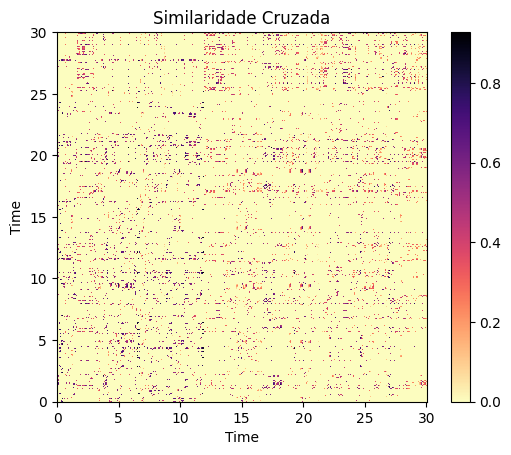

In [10]:

filename1 = 'pop.00019.wav'
filename2 = 'pop.00015.wav'

cross_similarity(filename1,filename2)


## Fechando a conexão


In [11]:
data.close()